# Analysing data with Python and MNE

Sebo Uithol, PhD, June 2023. Thanks to Jeshua Tromp and David Vogelsang for their help setting up this Jupyter Notebook.

Welcome to the practical session EEG data analysis! This practical session is part of the course Experimentation II at Leiden University. In this session we will study the EEG signals during an Eriksen Flankers Task. We will get acquainted with the basic preprocessing steps, the analysis of the data and the interpretation of the results.

The data that we will be analysing was recorded at Leiden University, with the same equipment that we have used during the data acquisition practical.

The data was acquired during an Eriksen flankers task. This is a conflict task that belongs to the same family of paradigms as the Stroop and Simon task. Participants are instructed to respond as fast as possible to the direction of the central stimulus in an array like this by pressing a response button with the corresponding index finger (in this case the right index finger) The experiment was a bit more complex than the standard Flankers task, but we will ignore this here.

![title](flankers.jpg)

Flanking stimuli around the target are irrelevant, but can prime the correct response (congruent), or the opposite response (incongruent). Immediately after stimulus presentation, the attentional spotlight (the area of stimulus information that is selected for further processing) has not yet been narrowed, so the dominant information derives from the flankers, which may point at the wrong response. As the spotlight is narrowed, the support for the correct response increases. In the ERP you are likely to see initial signs of motor preparation for the hand indicated by the flankers (LRP) and signs of error detection processes (ERN). In addition, the ERP will show large components such as the P300. Prior to the P300, there is a weak negative component that is sensitive to the presence of conflict in the decision processes (N200). We will see to what extent these waves can be identified and quantified. Some of these ERP peaks will be analysed in the following.



### Importing
Now it is time to start our python script. Before we can start loading the data, we need to have the proper tools in place. Obviously we need to import MNE. Next we import matplotlib, for data visualisation, pandas for data analysis, and numpy for working with data structures. If you don't like typing the same words over and over again, you can import libraries as a shorter name, for instance 'pandas' as 'pd'. This saves time later on, but it is optional.

In [1]:
import mne
import matplotlib
import pandas as pd
import numpy as np


### Creating paths
Next we will set up the folders, so that python knows where to look for what. Type in the path corresponding to the location where you stored the data. To keep things need, we stored the eeg data file and the behavioural data file in two separate folders.


In [2]:
dataPath = '/Users/sebouithol/surfdrive/Leiden/Teaching/Experimentation II/Data Analysis Practical/dataEEG/'
dataPathBehav = '/Users/sebouithol/surfdrive/Leiden/Teaching/Experimentation II/Data Analysis Practical/dataBehavioural/'




### Loading the data
Now we want to create an array with the content of the eeg data file. We do this using the command read_raw_bdf. This command is part of the MNE toolbox, and within MNE of the io (input-output)library, so the full command will read as: nameArray = mne.io.read_raw("file name")

We need to specify the filename within the brackets. For this we also make use of the path that we created above.

In [45]:
filename = "Flanker_EEG_52_12052022.bdf"
fullFileName = (dataPath + filename)

raw_eeg = mne.io.read_raw_bdf(fullFileName, preload=True)

Extracting EDF parameters from /Users/sebouithol/surfdrive/Leiden/Teaching/Experimentation II/Data Analysis Practical/dataEEG/Flanker_EEG_52_12052022.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1778175  =      0.000 ...  3472.998 secs...


We have managed to import the eeg data in python. At this point we may want to check what kind of data we have imported, so we use the command type:

In [31]:
raw_eeg.info

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 1 Stimulus
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2022-05-12 14:32:28 UTC
 nchan: 71
 projs: []
 sfreq: 250.0 Hz
>

An EEG data file is little more than the measured potential of a number of electrodes sampled at given frequency, stored as a very large 2-dimensional matrix. The size if the matrix is the number of channels for one dimension, and the sampling frequency timed the duration of the recording in seconds.

To make sense of this matrix, we will also have to specify what the locations of each of the electrodes is. Luckily we do not have to do this by hand. MNE has dictionaries (or rather atlases) of standard systems. Ours is called biosemi64. If we use this, the location of each of the electrodes is provided. Additionally, we will specify that EXG1 through EXG6 are used to track eye movements (eog channels). We will drop EXG7 and EXG8, as they were not used during the recording.

In [47]:
biosemi_montage = mne.channels.make_standard_montage("biosemi64")
raw_eeg.set_montage(biosemi_montage, on_missing='ignore')
raw_eeg.set_channel_types(
    {'EXG1': 'eog', 'EXG2': 'eog', 'EXG3': 'eog', 'EXG4': 'eog', 'EXG5': 'eog', 'EXG6': 'eog'})
raw_eeg.drop_channels(['EXG7', 'EXG8'])  # Unused channels

ValueError: Channel(s) EXG7, EXG8 not found, nothing dropped.

If you want to check the location of the sensors, you can use the plot_sensors command. Which naming and location convention is displayed?

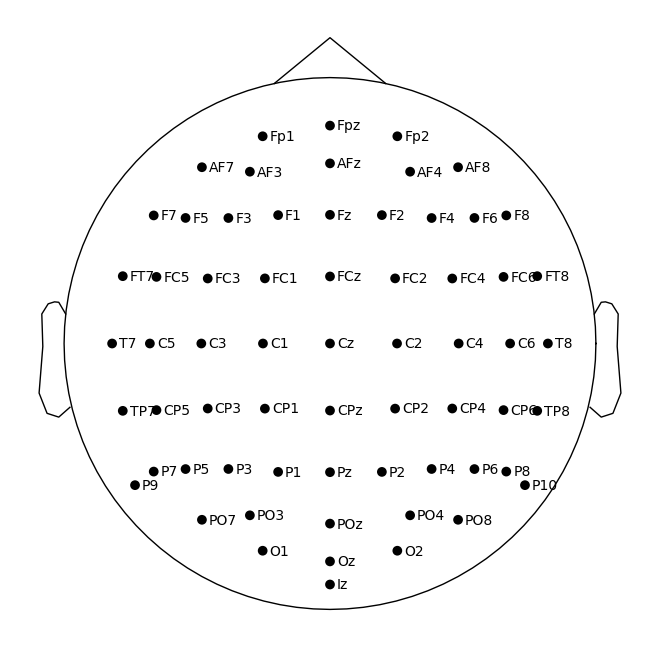

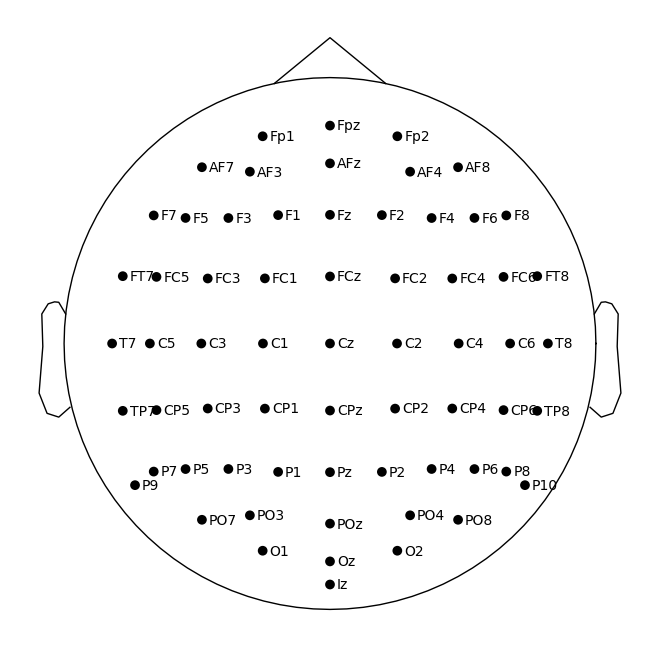

In [66]:
raw_eeg.plot_sensors(show_names=True)
#fig = raw.plot_sensors("3d")

We have loaded the data, and specified some of the characteristics. Now it is time to preprocess the data.

# Preprocessing
EEG preprocessing encompasses multiple steps. Generally, these steps are different in every experiment, as they are dependent on the research question, the recording setup, and the subsequent analysis steps. So there is no one-size-fits-all method. The steps below are common in many analysis pipelines.

### Downsampling
In the output above we can find all kinds of characteristics of the data file. For instance, you can see that 72 electrodes have been used. That the recording took almost an hour, and that the analogue signal was sampled with a 512Hz frequency. For our purpose this is a bit too high, which will make files unnecessarily big, and computations slow. So we will _downsample_ the data. This will be done using the resample command. We will have to specify the sfreq for this. You can add this in the code below. Use a value of 250. Note that we could have recorded this data with a sampling frequency of 250 from the start, which would have saved us the downsampling step. Yet, this latter option would have resulted in data of lesser quality. Do you understand why? Have a look at the command below. Do you understand the syntaxis? What is raw_eeg doing at both sides of the '=' sign?

In [48]:
raw_eeg = raw_eeg.resample(sfreq=250)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
2823 events found
Event IDs: [    4     8    16    33    34    35    36 65536 65789]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
2823 events found
Event IDs: [    4     8    16    33    34    35    36 65536 65789]


If you want to check whether it was successful you can use the .info command again

In [17]:
raw_eeg.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2022-05-12 14:32:28 UTC
 nchan: 71
 projs: []
 sfreq: 250.0 Hz
>

### Rereferencing
You may remember from the lecture that the potential that is recorded at each electrode is not an absolute value, but always a difference between that electrode and another electrode. You may also remember that during the acquisition we have used two electrodes named 'drl' and 'cms' as a reference during recording, and that we placed two electrodes on the mastoids in addition. Since drl and cms were close to the active electrodes, they are not ideal for analysing the data. The mastoids are further away from the active electrodes, and not near the brain, which will make them a far better reference. We will set the average of these two channels as explicit reference for all the other electrodes. Can you explain the procedure? Could we have placed cms and drl directly on the mastoids?


In [49]:
raw_eeg.set_eeg_reference(ref_channels=['EXG5', 'EXG6'])  # Take average of mastoids as reference


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEDF | Flanker_EEG_52_12052022.bdf, 71 x 868250 (3473.0 s), ~470.4 MB, data loaded>

Now let's have a quick inspection of what the raw data looks like.

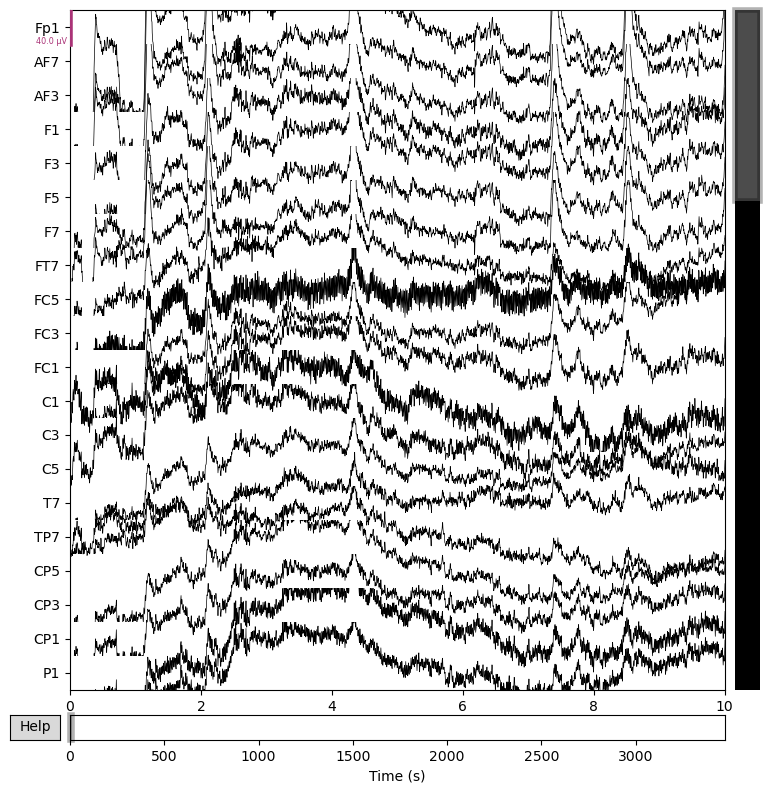

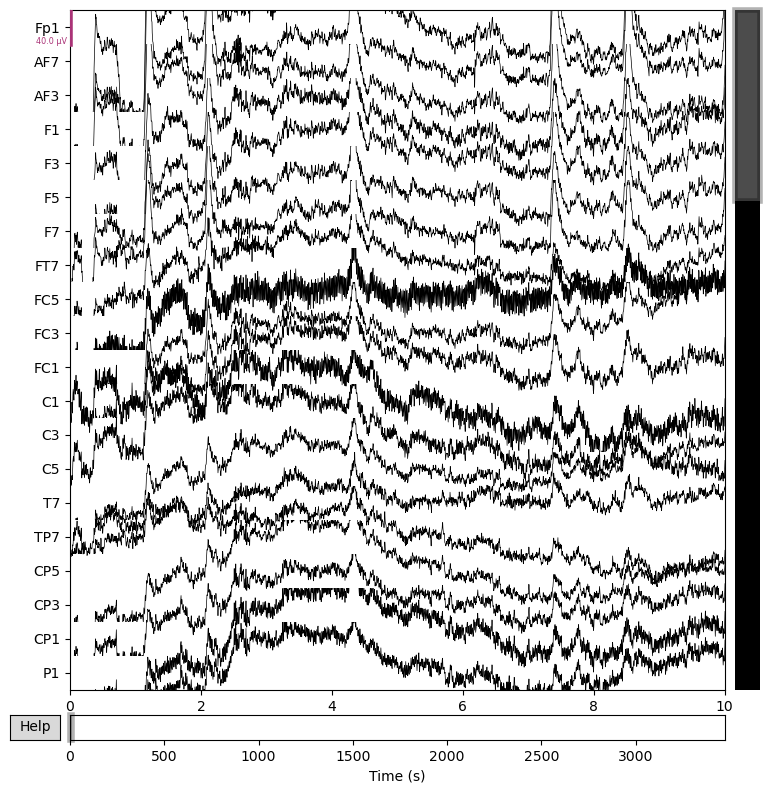

In [50]:
mne.viz.plot_raw(raw_eeg)

ValueError: ch_type must be one of ('mag', 'grad', 'eeg', 'csd', 'seeg', 'ecog', 'dbs', 'hbo', 'hbr', 'fnirs_cw_amplitude', 'fnirs_fd_ac_amplitude', 'fnirs_fd_phase', 'fnirs_od') not eog!

Ok, it is clearly data, but it does not vry  look pretty. It still contains various types of noise, and at multiple places the recorded value is too small or large to be displayed in the given range. In different steps we will correct these problems.

### Filtering
The EEG signal can be constructed as an assembly of sinus waves of different frequencies, phase, and strength (a Fourrier Analysis). Of some of these frequencies, the very low and very high ones, we can be sure that they do not correlate to brain activity. Low frequencies may be attributed to amplifier drift, or sweat. We use a so-called _high-pass_ filter to discard this frequencies High pass means that frequencies higher than a certain threshold can 'pass' the filters; lower frequencies are filtered out.
Higher frequencies we filter out using a _low-pass filter_. There is some controversy around the source of high frequencies in the EEG signal. We are certain that line noise (50Hz in Europe) and muscle activation contribute to this frequency range, but there seems to be evidence that higher frequencies can also originate from the brain. So you have to choose the threshold frequency of your low-pass filter wisely, dependent on your research question.

Note that the names of the two filters always cause confusion. The value of a low-pass filter is always higher than that of a high-pass filter. Check whether you can explain why.

Here we will use a high pass setting of 0.1 Hz. This is relatively conservative filtering (everything slower than 10 second oscillations will be removed), but choose this setting because our independent component analysis will work better this way. We can of course choose to do another filtering step after the ICA. If you try you will see that your data will already look a bit better.

In [51]:
low_cut = 0.1
high_cut = 30
filtered_eeg = raw_eeg.filter(low_cut, high_cut, fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.6s finished


Let's have a look at what the data looks like now. Use the same plot command as above, but this time plot the new array.

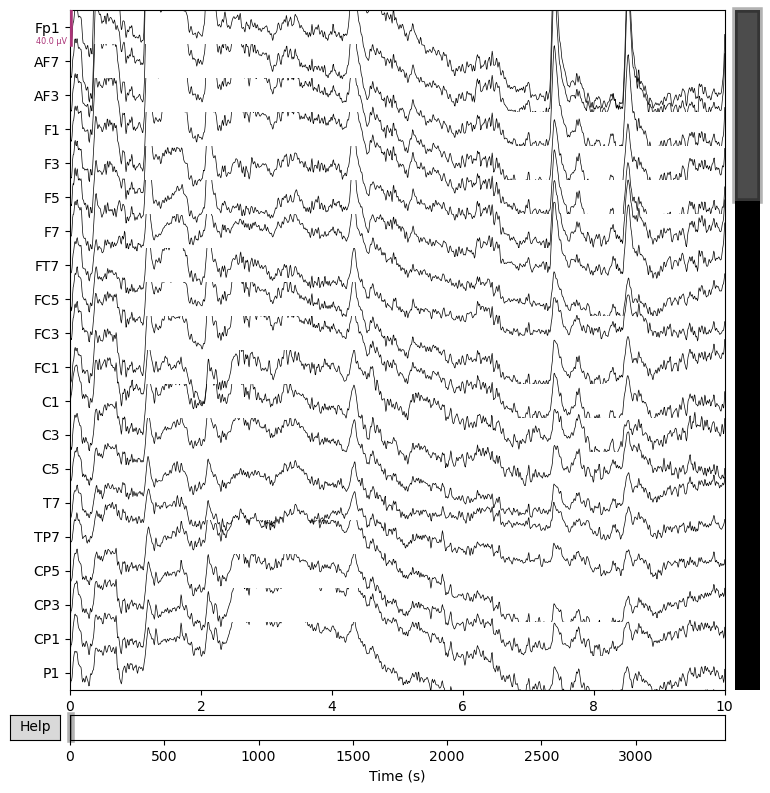

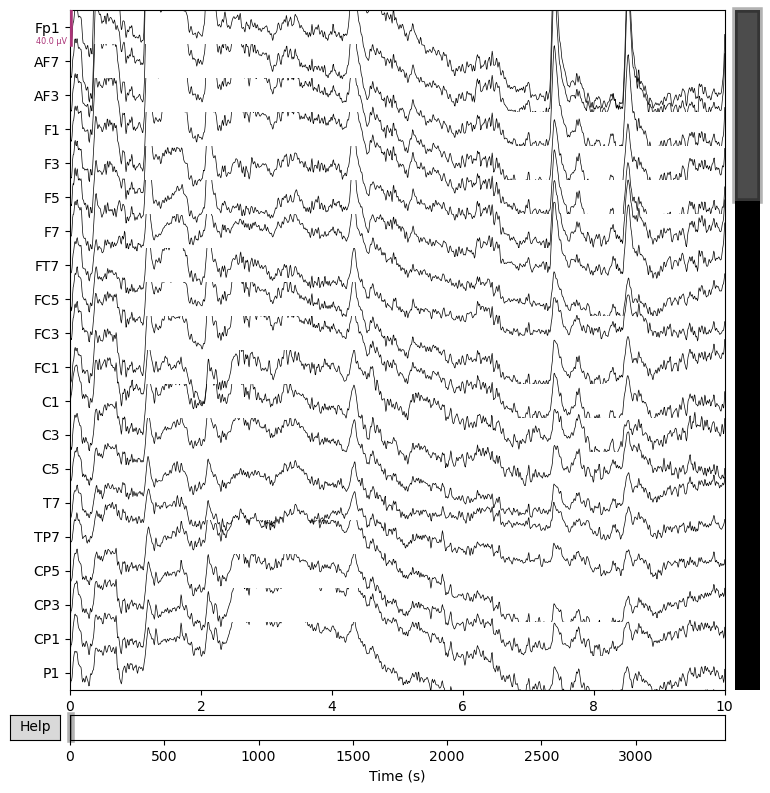

In [52]:
mne.viz.plot_raw(filtered_eeg)

This already looks a bit better, but we still need to remove the artifacts that originate from eye movements (blinks and saccades). We will do this using an _Independent Component Analysis_.



#### Independent Component Anlysis
To understand an Independent Component Analysis (ICA), think of a number of musicians playing in a room, while being recorded by multiple microphones. Each microphone picks up the sound of all the musical instruments, but, importantly, at different strengths. An ICA is a mathematical procedure to re-construct the sound of each individual instrument based on the signals of each of the microphones. The number of instruments that can thus be isolated is limited by the number of microphones.
Back to EEG data preprocessing: The raw signal is composed of proper brain activation as well as artifacts such as eye-blinks and saccades. What we want to do is identify components that can be related to occular artifacts, and then subtract these components from the raw signal. What would be left is a signal that does not include the contribution of these noise components. Here the number of components that can be estimated is limited by the number of electrodes. Since this data was recorded using 64 channels, we have ample components at our disposal.


In [40]:
from mne.preprocessing import ICA


method = 'picard'

n_components = 20 # select n_components by explained variance of PCA
random_state = 23 # Random seed

ica = ICA(n_components=n_components, method=method, random_state=random_state)
ica.fit(filtered_eeg, reject=None)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 33.6s.


<ICA | raw data decomposition, method: picard (fit in 61 iterations on 868250 samples), 20 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Now let us plot these components for a visual inspection. The components are ranked ordinally, the first component explaining the most of the variance in the data, the last component the least. We can plot the contribution of the different components over time, but also the location of the component.

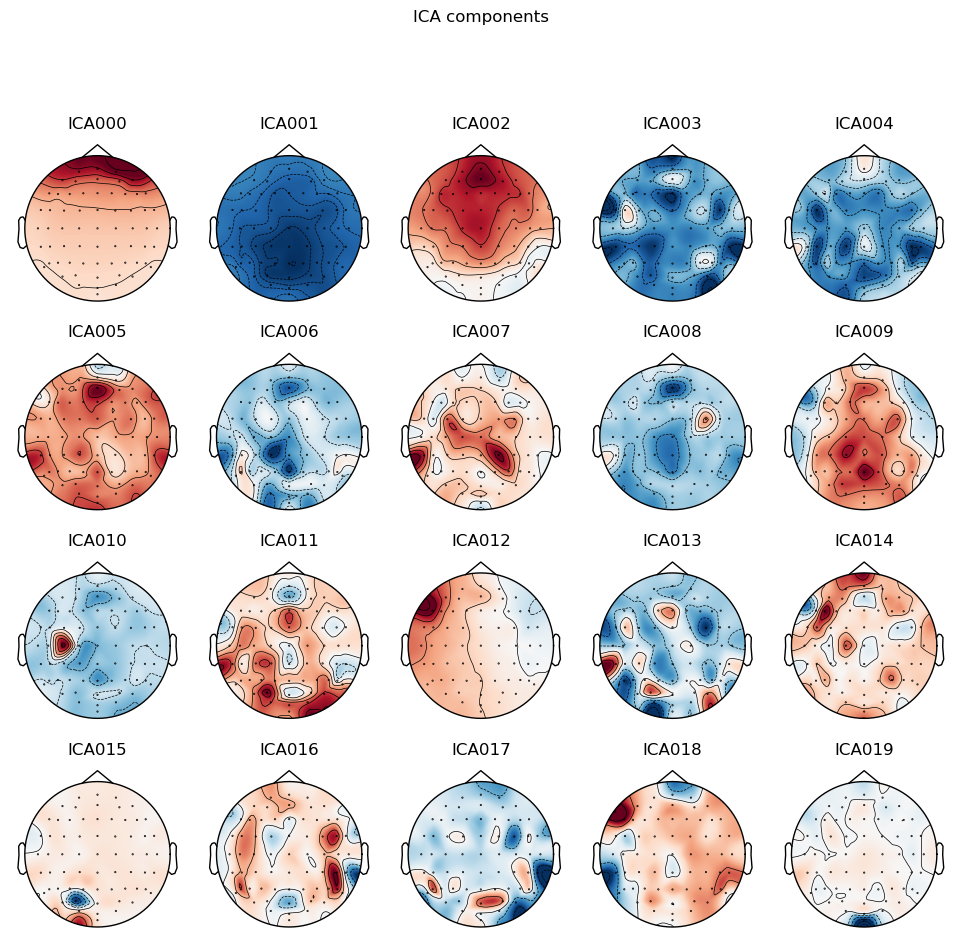

Creating RawArray with float64 data, n_channels=26, n_times=868250
    Range : 0 ... 868249 =      0.000 ...  3472.996 secs
Ready.


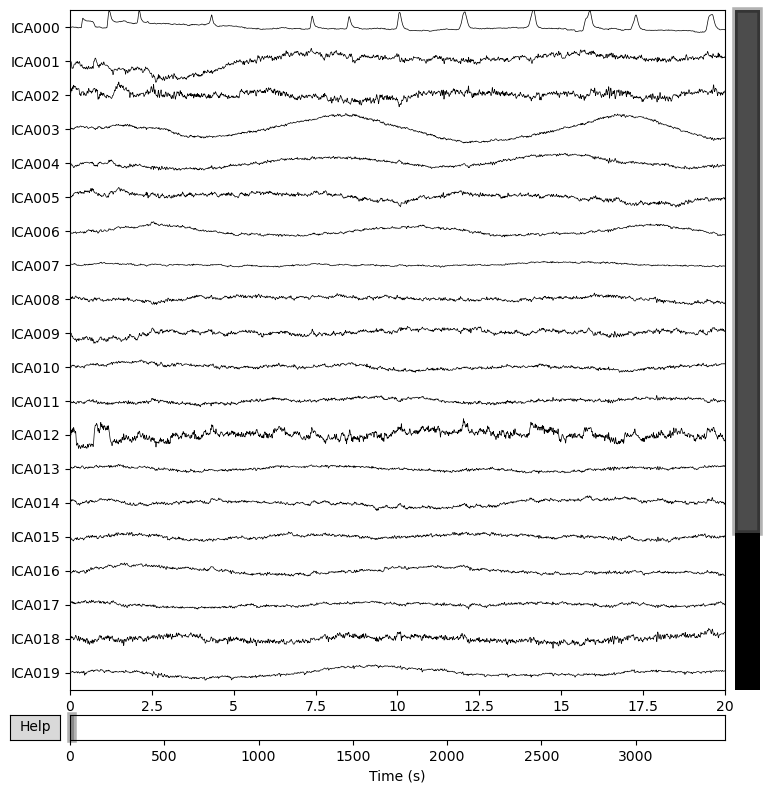

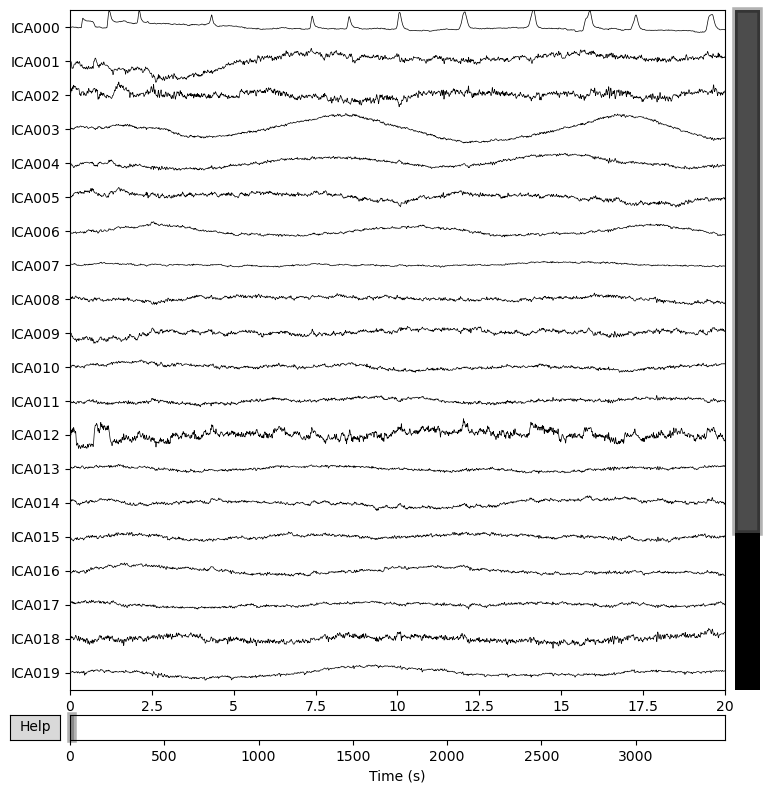

In [41]:
ica.plot_components()
ica.plot_sources(filtered_eeg)


For best results we look at both the components and the sources. Note that the sources graph does not display the electrodes, but the different components. The graph indicates how much of the (in our case filtered eeg signal) is explained by each component. What component correlates with eye blinks, you think? Why? What component could correlate to a bad sensor connection? We will remove it from the data.

Fill in the components number in the brackets below. Mind that the first member in an array in python is referred to as 0 (unlike for instance MatLab, where the first member is 1)

In [67]:
ica.exclude = [0, 2, 12]
cleaned_eeg = ica.apply(filtered_eeg)


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


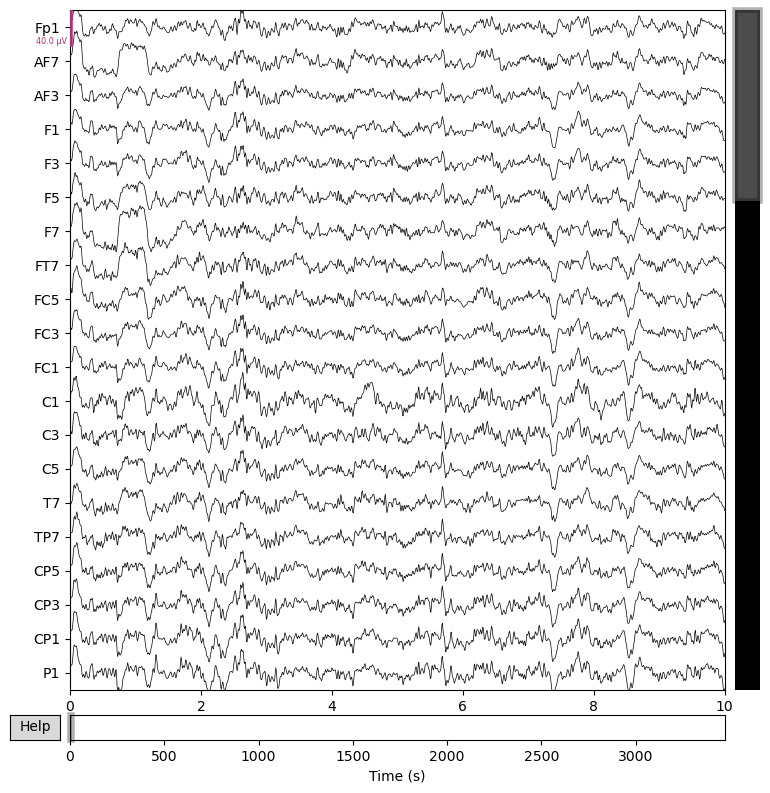

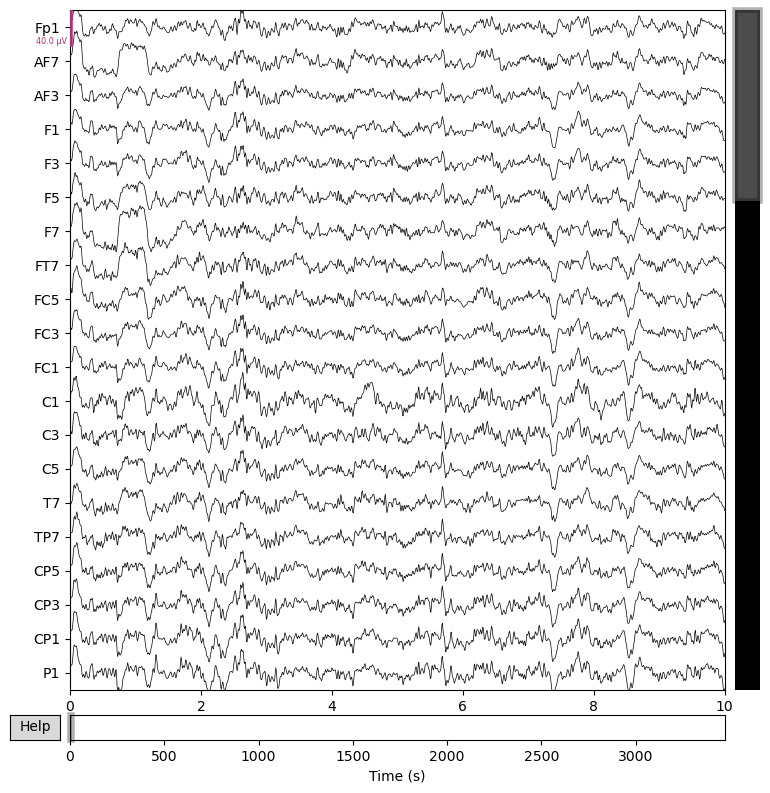

In [68]:
mne.viz.plot_raw(cleaned_eeg)



### Filtering again
That looks a whole lot better! Remember that we filtered quite conservatively because of the ICA that we planned to do. We can do another, slightly less conservative round of filtering to get rid of the frequencies between 0.1 and 1 Hz. They are certainly not related to brain activity, so better discarded. These steps and settings can  be changed and even repeated, as we do here, as long as you are transparent about it when publishing the results.

So now we run another band pass filter, but this time with the low_cut set to 1, and we plot the results immediately.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.2s finished


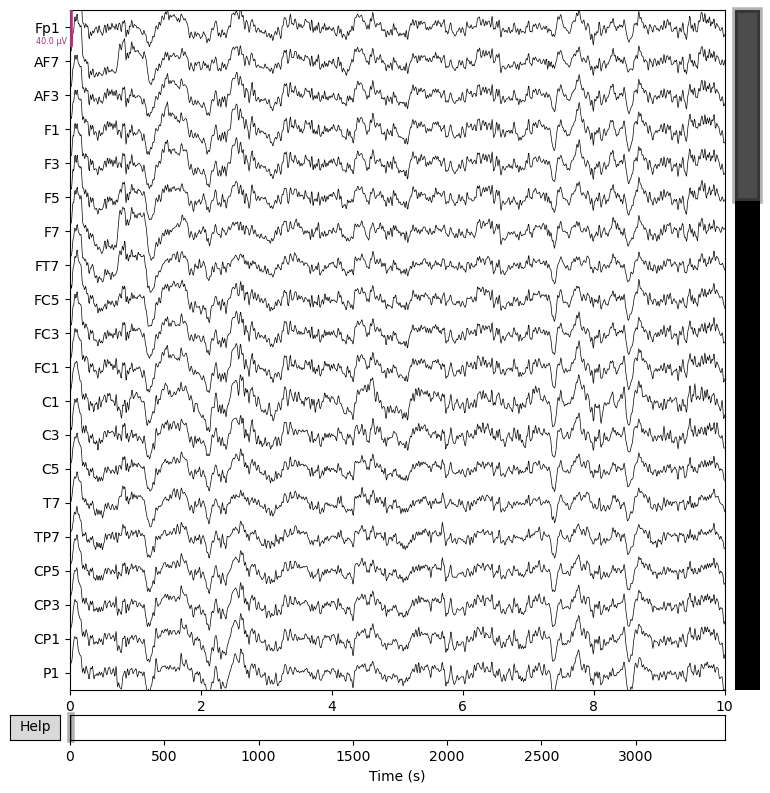

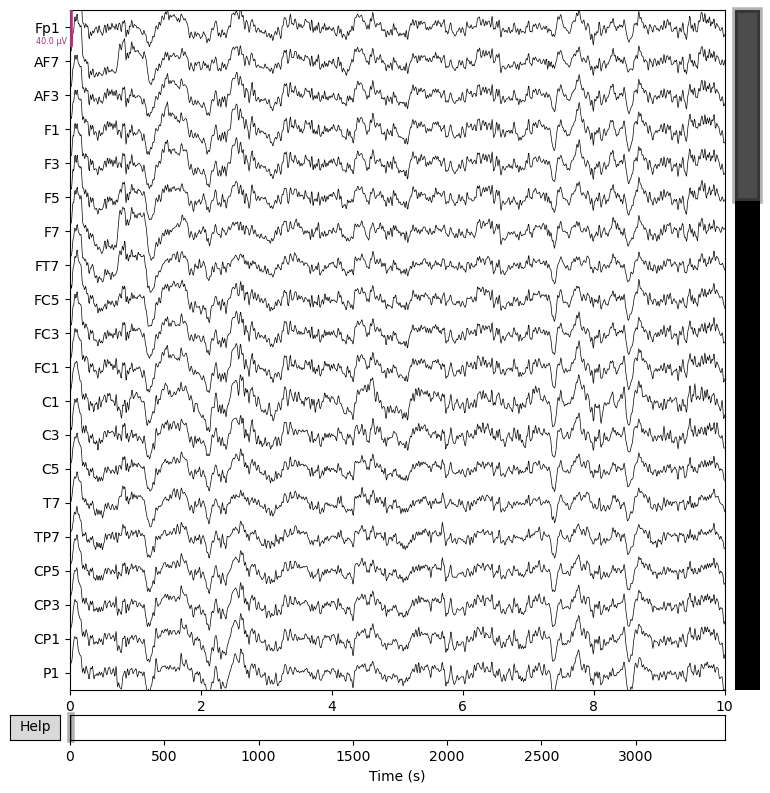

In [63]:
low_cut = 1
high_cut = 30
cleaned_eeg = cleaned_eeg.filter(low_cut, high_cut, fir_design='firwin')
mne.viz.plot_raw(cleaned_eeg)

This is starting to look like nice usable data! Now it is time to relate it to behavioural events

### Loading the behavioural data

Because MNE is a python toolbox, the possibilities to combine eeg with behavioural data are unlimited. In this case, the behavioural data is stored in a separate text file. I will not explain this step in detail, as it is very specific to the experiment, but have a look at the code, and see whether you understand what is happening. Crucial is that in this task on half of the trials the participant was given an alert on beforehand, and on half of the trials this alert was absent, like with the classical Flankers task.

In [55]:
fileNameBehav = "flankertask_eyetracker_52_202205121431_format.txt"
fullFileNameBehav = dataPathBehav + fileNameBehav


# Load in behavioral data and make numpy array of trialtype
trials = pd.read_csv(fullFileNameBehav, sep=",")
trials['RT'].replace('None', np.nan, inplace=True)  # Replace "none" answers with "nan" for int processing
trials['RT'] = pd.to_numeric(trials['RT'], errors='coerce', downcast='integer')

trials['condition'] = trials['trialtype'] + ' ' + trials[
    'alert']  # Make condition column, with alert and trialtype
trials_num = trials[['condition']].to_numpy()

# Change coding of trialtype, and reshape to appropriate dimension for later processing
trials_num = np.where(trials_num == "congruent alert", 1, trials_num)
trials_num = np.where(trials_num == "congruent no_alert", 2, trials_num)
trials_num = np.where(trials_num == "incongruent alert", 3, trials_num)
trials_num = np.where(trials_num == "incongruent no_alert", 4, trials_num)
trials_num = np.where(trials_num == "catch alert", 5, trials_num)
trials_num = trials_num.reshape(720)

# Transfer the stimulus EEG triggers to an MNE event file
events = mne.find_events(raw_eeg, uint_cast=True, consecutive=False)

# Delete all markers except for "alert_onset" (34) --> we will use that to orient ourselves
# Note that there were also "alert_onset" triggers in no_alert trials, these were just silent
events_trials = mne.pick_events(events, exclude=[4, 8, 16, 33, 35, 36, 253])

# Merge trials_num and events_trials: replace third column np array with trials_num that contain trial condition
events_trials[:, 2] = trials_num

# alert-centered to flanker centered (+500)
events_trials[:, 0] = events_trials[:, 0] + (500 * (raw_eeg.info['sfreq'] / 1000))
# Dictionary of numbers
event_dict = {"congruent alert": 1, "congruent no_alert": 2,
              "incongruent alert": 3, "incongruent no_alert": 4,
              "catch alert": 5}

2813 events found
Event IDs: [  4   8  16  33  34  35  36 253]


Now it is time to convert the continuous signal into chunks of data that are linked to one of the experimental conditions. We call these chunks _epochs_. We use the behavioural data that we have loaded above to define the epochs. We specify how much time before, and how much time after the event we want to include into our epoch.


In [64]:
tmin=-0.6
tmax = 0.7  # epoch from 0.6s before flanker onset to 0.7s after it

epochs = mne.Epochs(cleaned_eeg, events_trials, event_dict, tmin, tmax, baseline=None,
                    metadata=trials, preload=True)

Adding metadata with 11 columns
720 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 720 events and 326 original time points ...
0 bad epochs dropped


We can now plot the epochs using the epochs.plot command (mind the capital E here!)

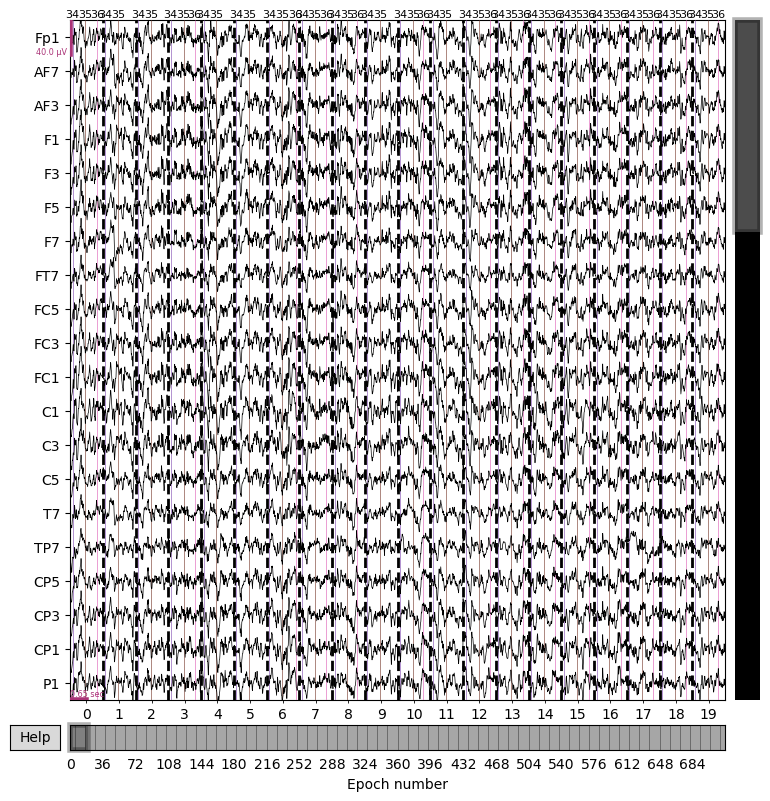

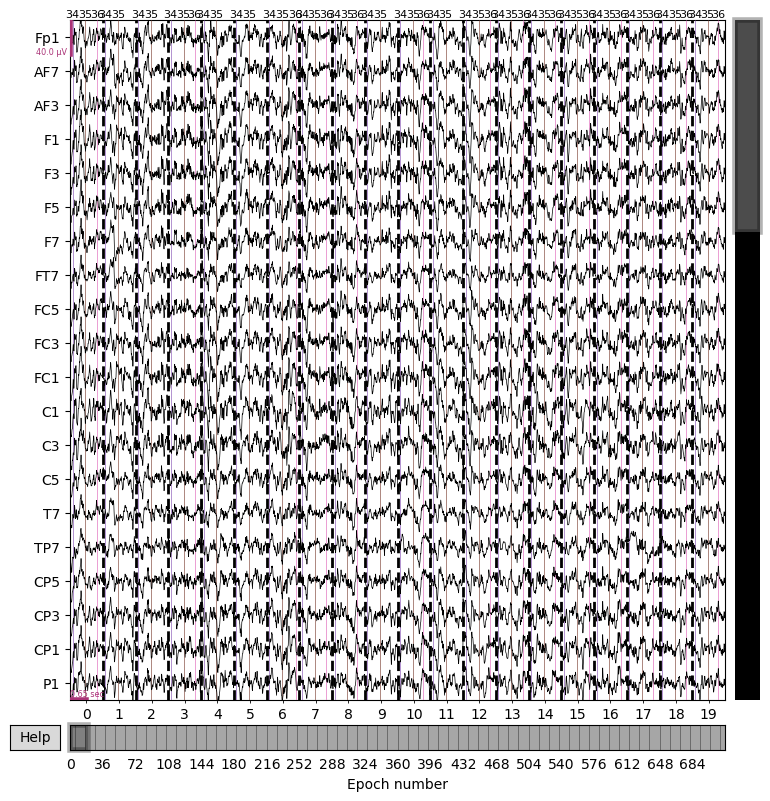

In [86]:
epochs.plot(events=events)
#mne.Epochs.plot(epochs)

Now it is time to make averages of all epochs belonging to one condition.

In [80]:
congNoAl = epochs["congruent no_alert"].average()
incongNoAl = epochs["incongruent no_alert"].average()
congAl = epochs["congruent alert"].average()
incongAl = epochs["incongruent alert"].average()


and again, we can plot them:

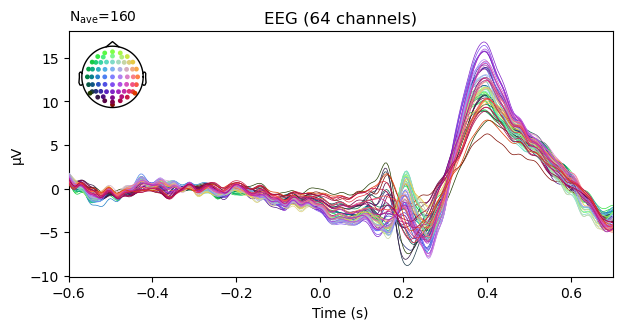

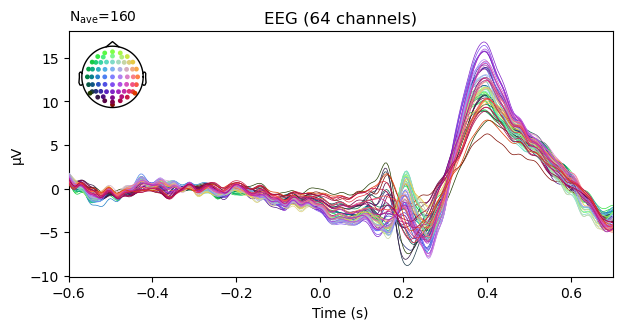

In [75]:
congNoAl.plot()



Look at the plots carefully. What is shown is the ERP for every electrode overlayed on top of each other. Two observations may need explication. 1) The ERP is visible in every electrode. This is inherent to EEG data and its poor spatial resolutions. If we want to do source localisation we will have to use the difference between the ERP peaks and troughs of the various electrodes. You can see that during the positive peak at around 200ms, the spread over the scalp is quite good, with the greenish tints (frontal electrodes) are more positive thah the blue/purpel electrodes. 2) The ERP components are much larger than the noise before 0s. This means that our recording and preprocessing step was succesfull and that the signal-to-noise ration is likely to be good enough to do analyses.

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/ym/sgmmtl6j62gdmqhqjzgb95_00000gn/T/ipykernel_80126/1077671167.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine="mean")


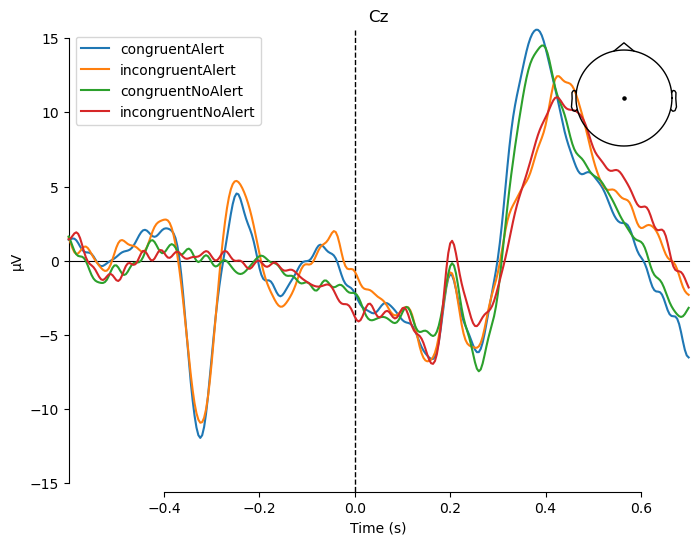

[<Figure size 800x600 with 2 Axes>]

In [84]:
evokeds = dict(congruentAlert=congAl, incongruentAlert=incongAl, congruentNoAlert=congNoAl, incongruentNoAlert=incongNoAl)
picks = ["Cz"]
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine="mean")

We can see that the difference between alert and no alert conditions is big at around 300ms before stimulus onset, but virtually absent in the peaks +400ms. In this peak we can see a difference between the congruent and incongruent conditions, irrespective of the alert.

In [ ]:
raw.plot_sensors(kind='3d', ch_type='eeg')

In [ ]:
raweeg.compute_psd(fmax=50).plot

Effective window size : 1.024 (s)


/Users/sebouithol/opt/anaconda3/envs/experimentationConda/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


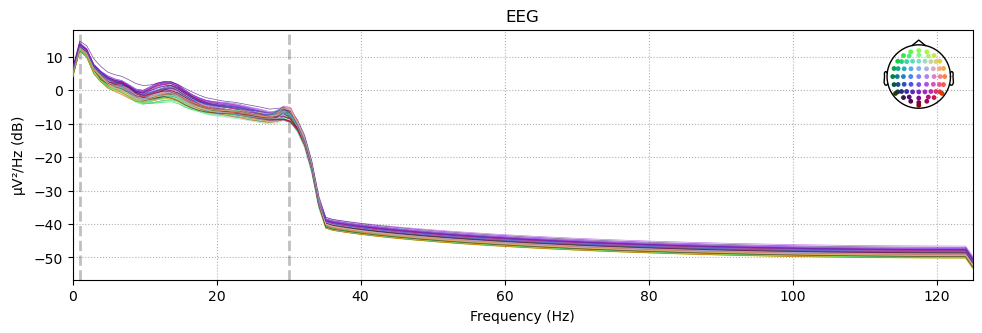

In [90]:
raw_eeg.compute_psd().plot()

In [0]:
frequencies = np.arange(5, 30, 2)
power, itc = mne.time_frequency.tfr_morlet(epochs, n_cycles=2, return_itc=True,
                                           freqs=frequencies, decim=3, average=True)

No baseline correction applied


/Users/sebouithol/opt/anaconda3/envs/experimentationConda/lib/python3.8/site-packages/mne/time_frequency/tfr.py:1499: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figs = [plt.figure() for i in range(n_picks)]


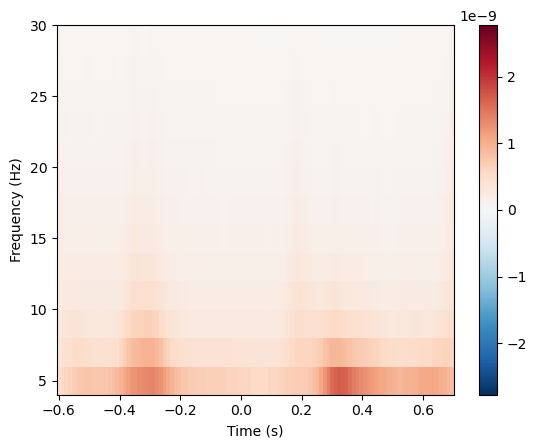

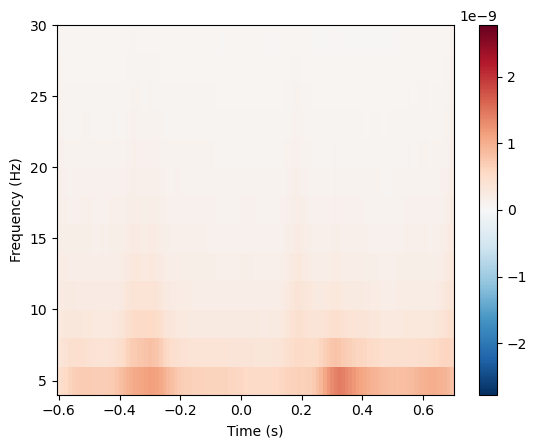

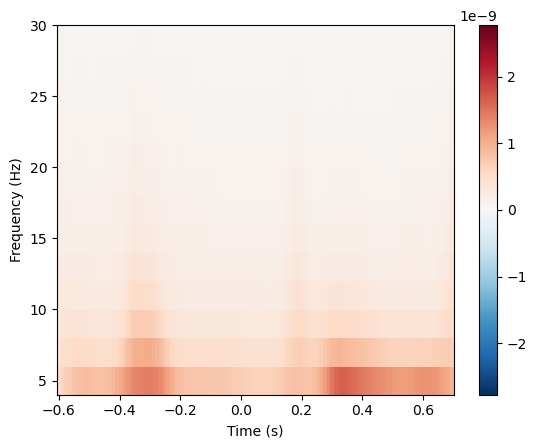

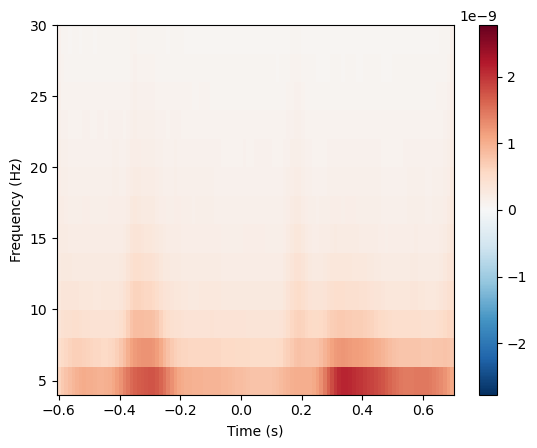

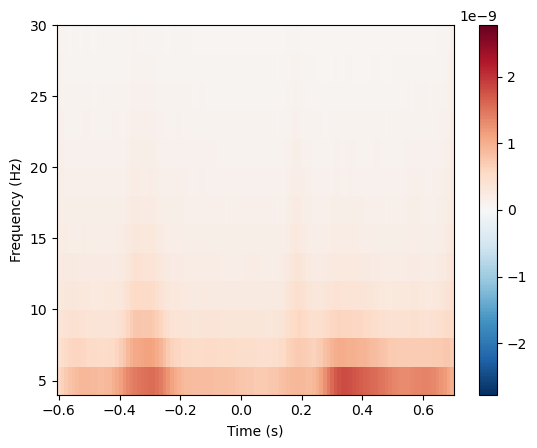

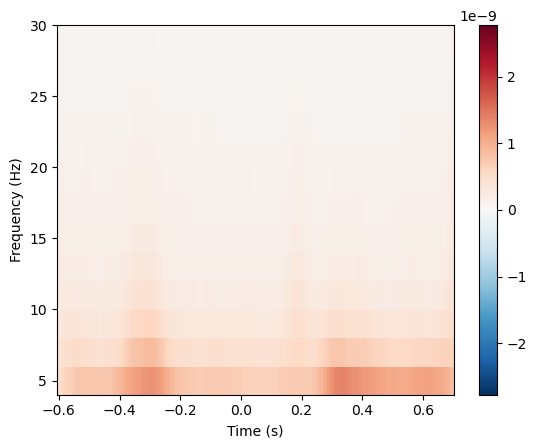

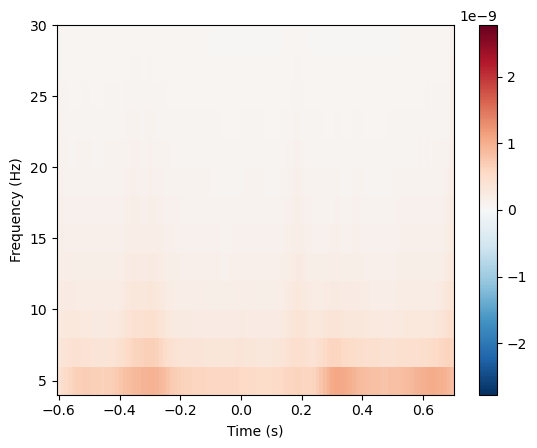

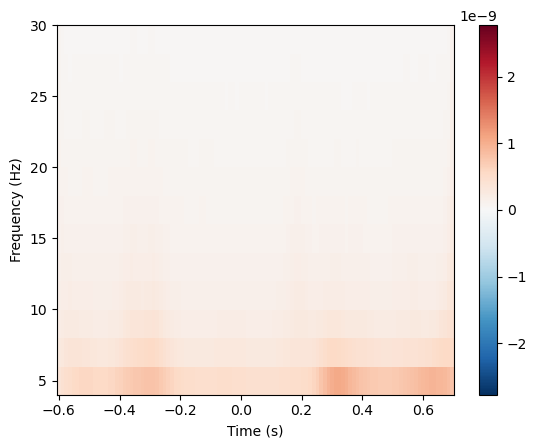

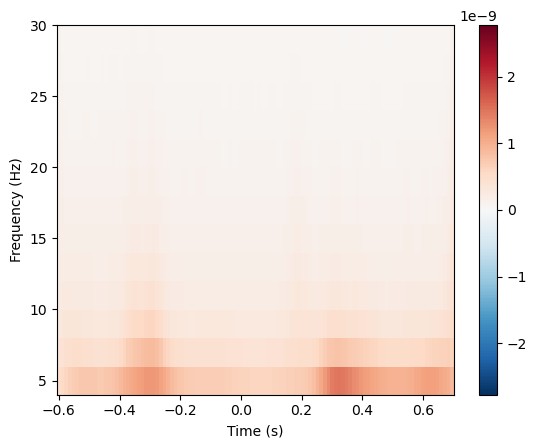

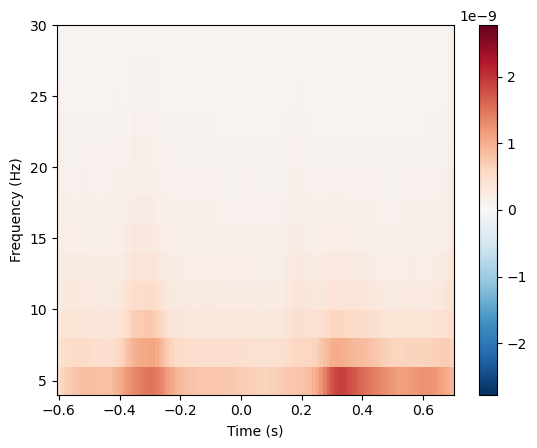

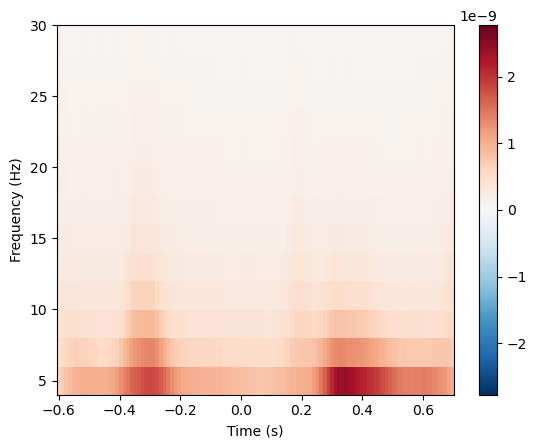

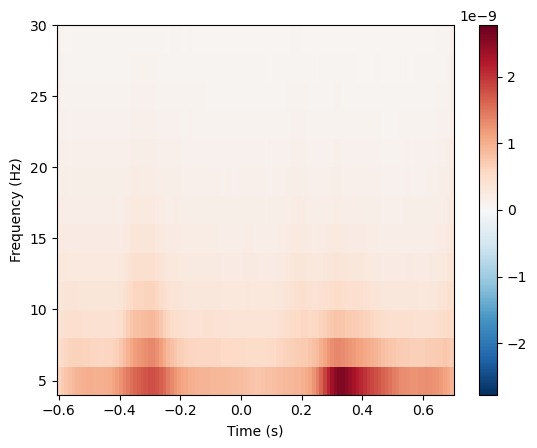

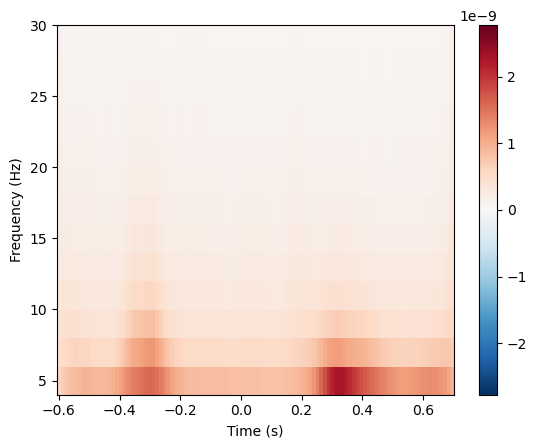

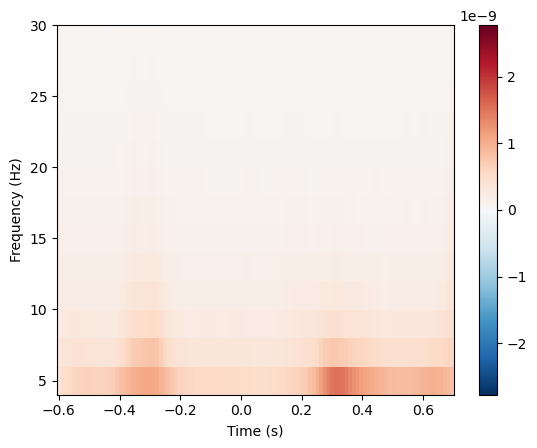

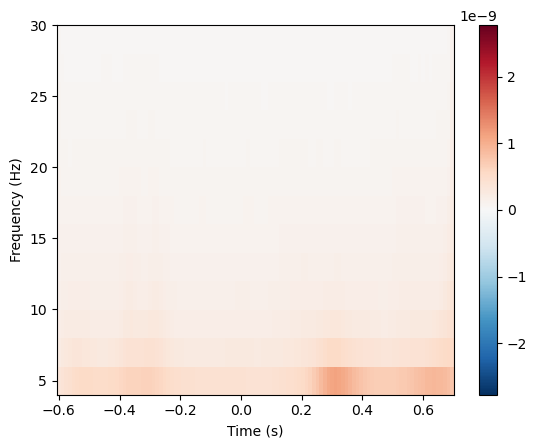

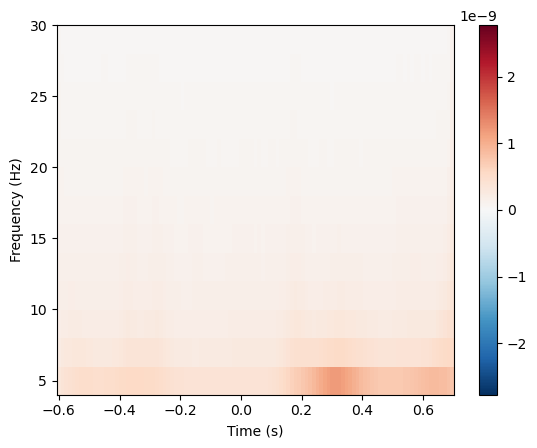

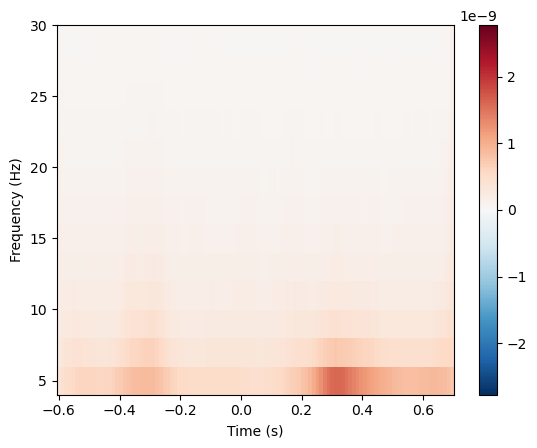

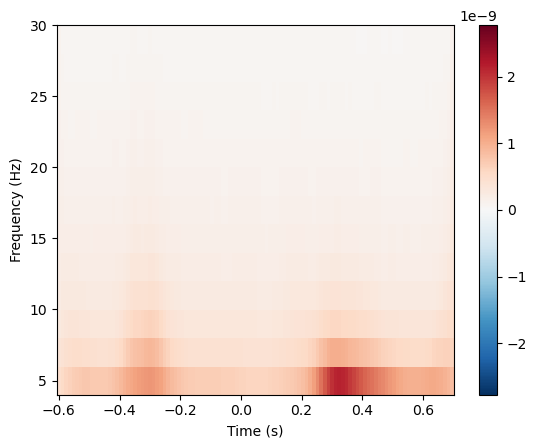

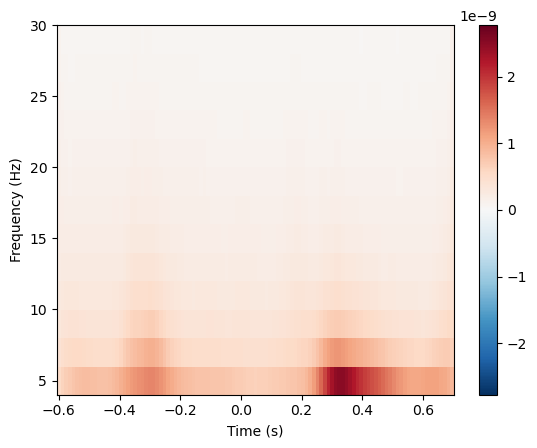

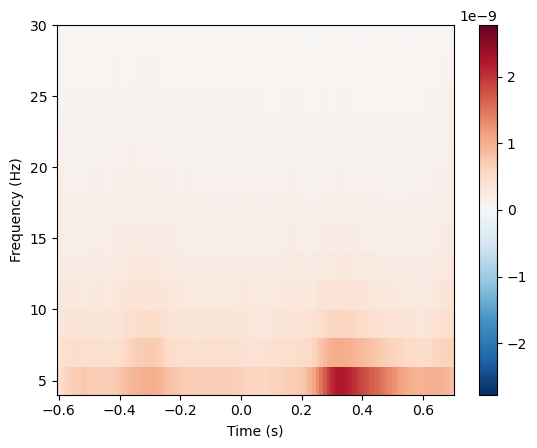

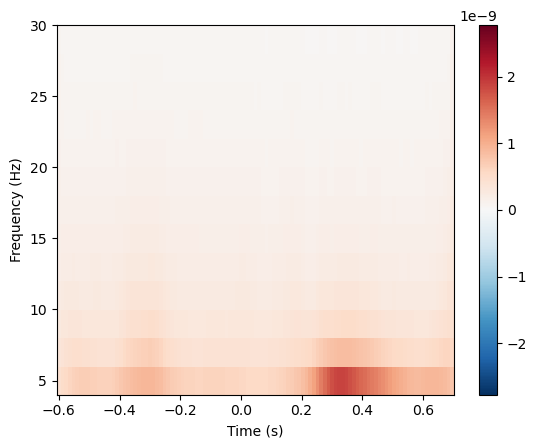

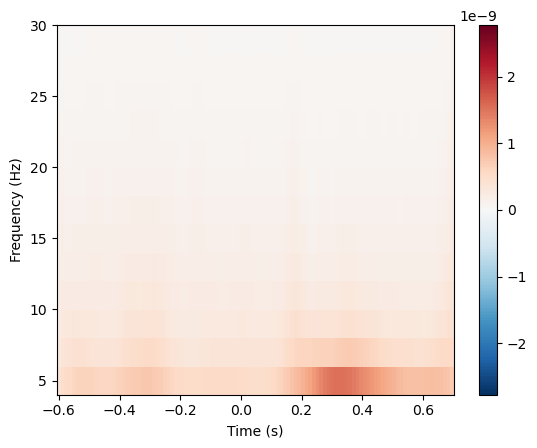

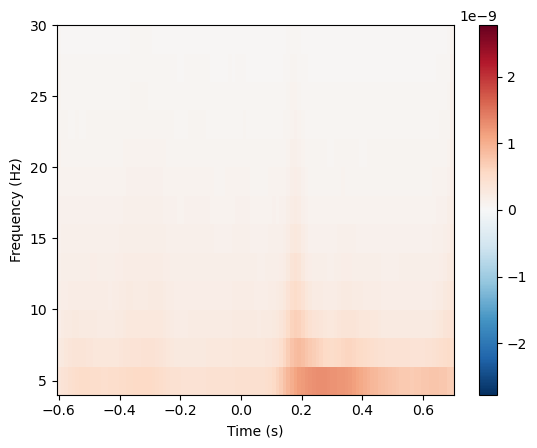

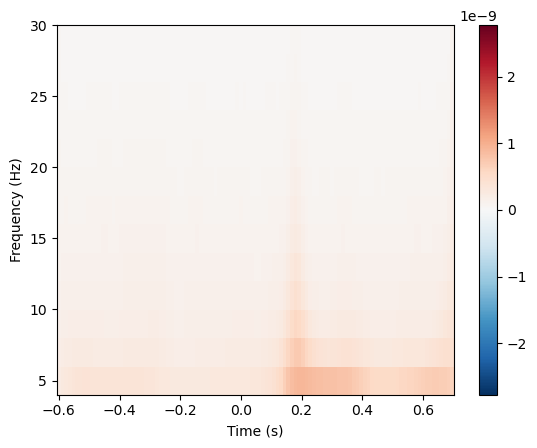

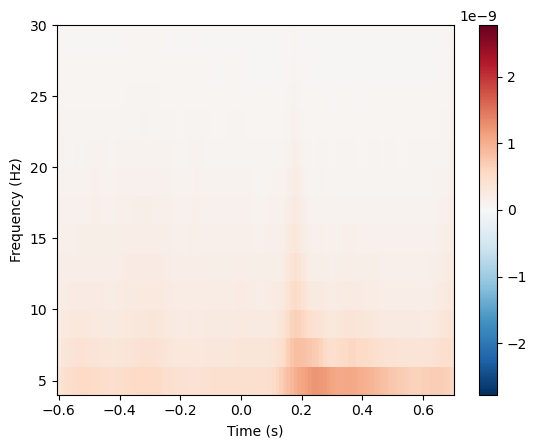

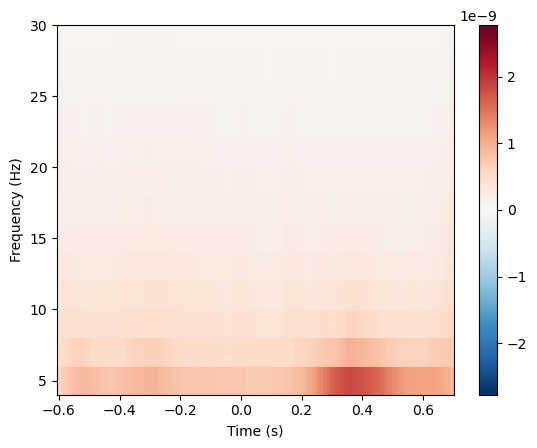

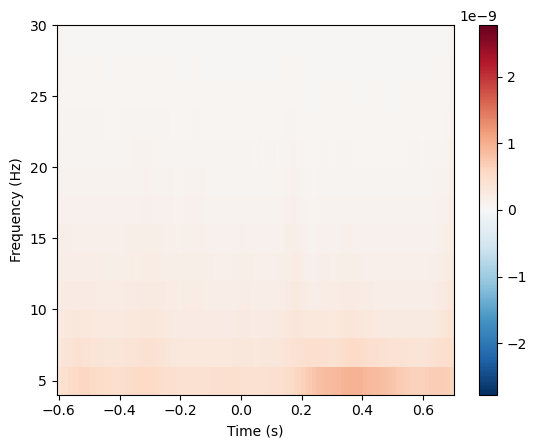

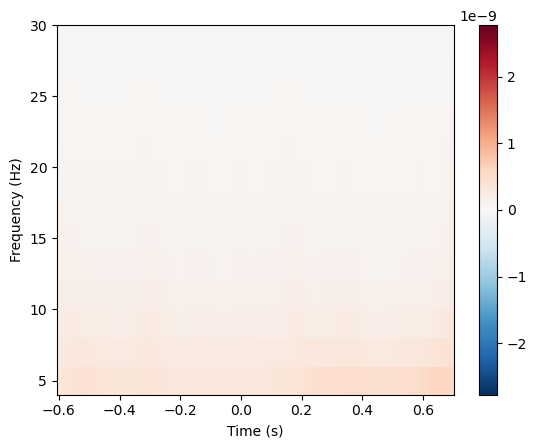

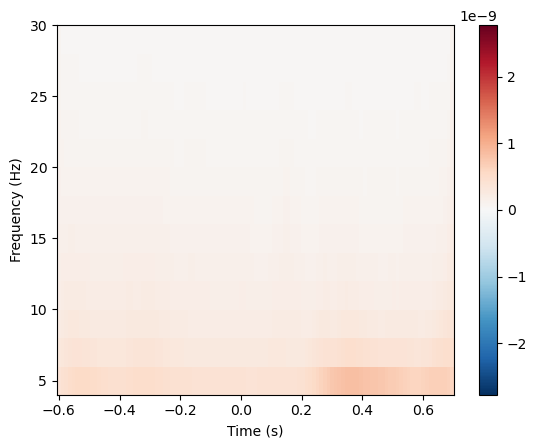

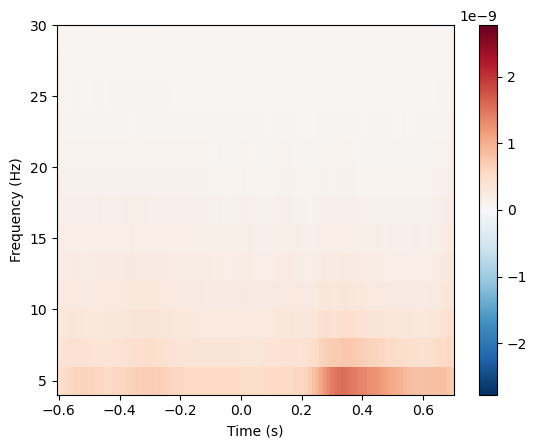

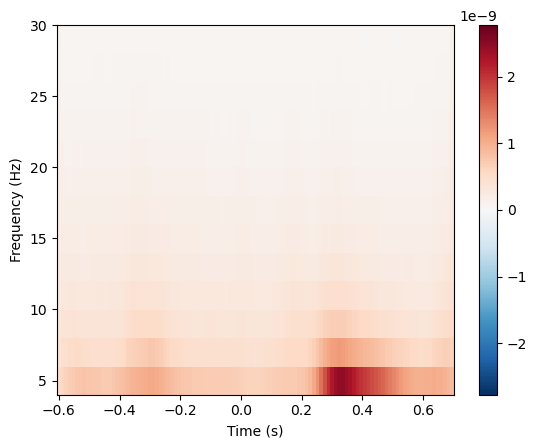

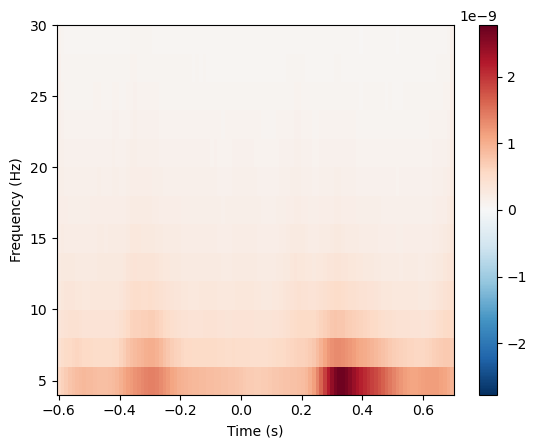

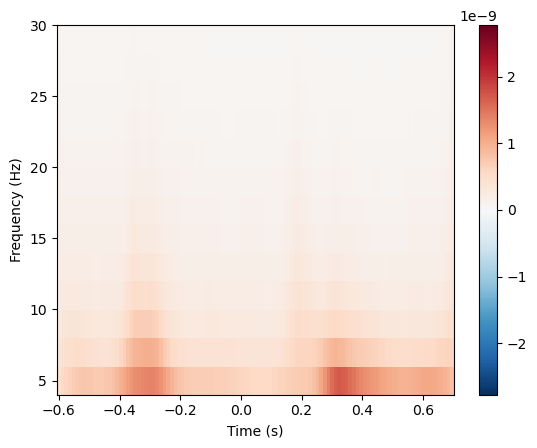

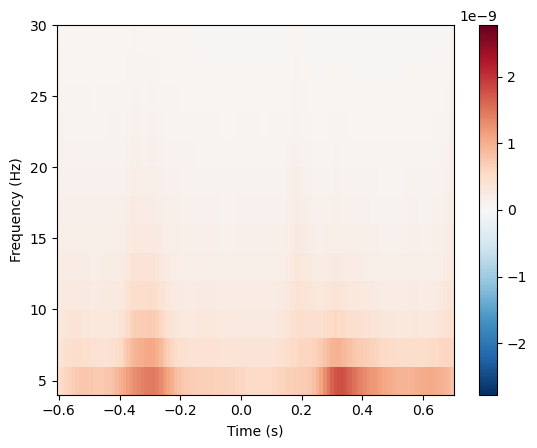

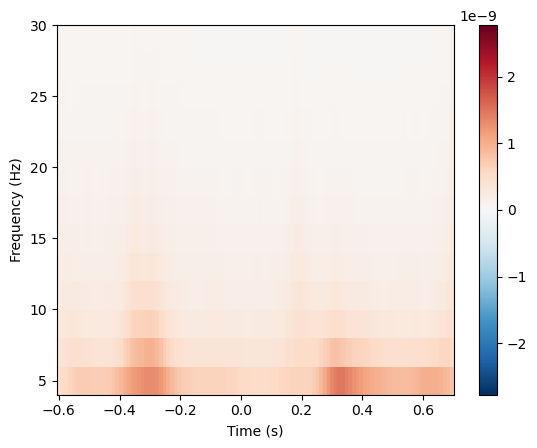

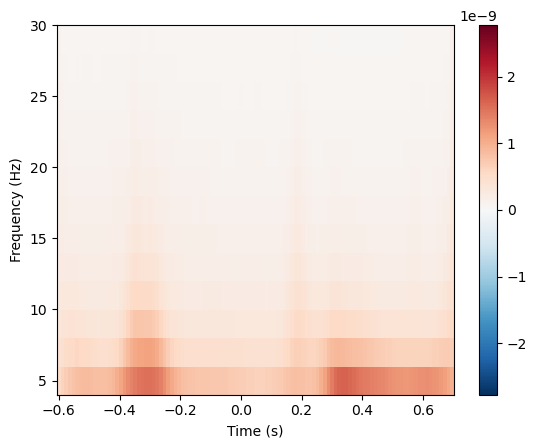

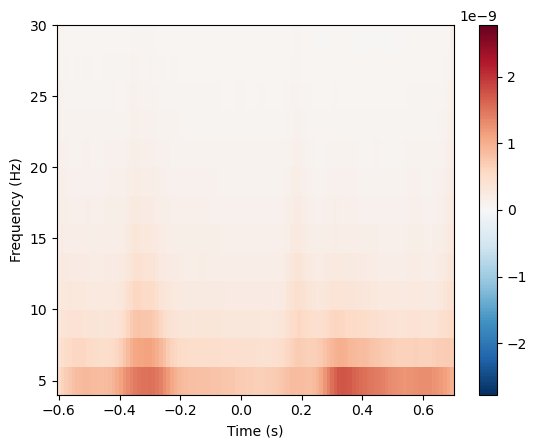

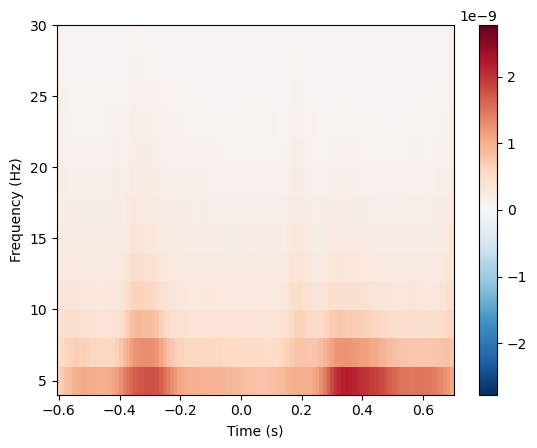

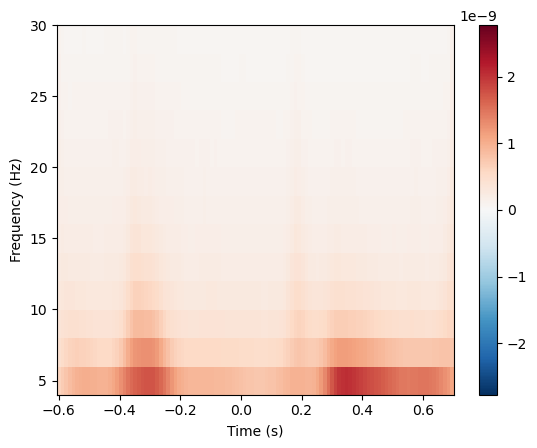

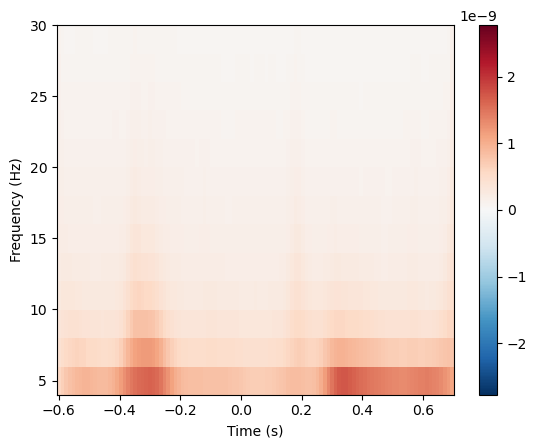

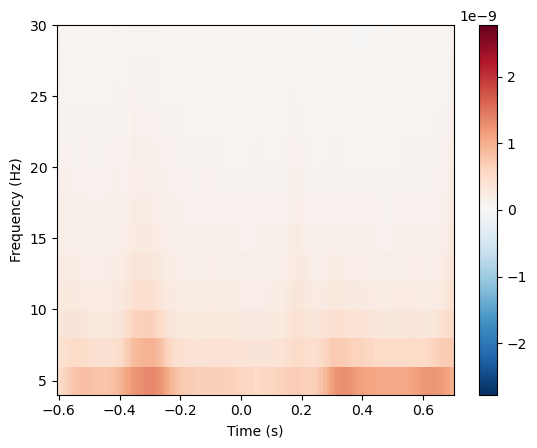

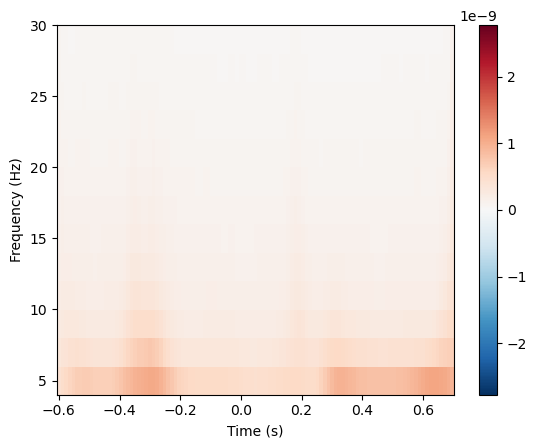

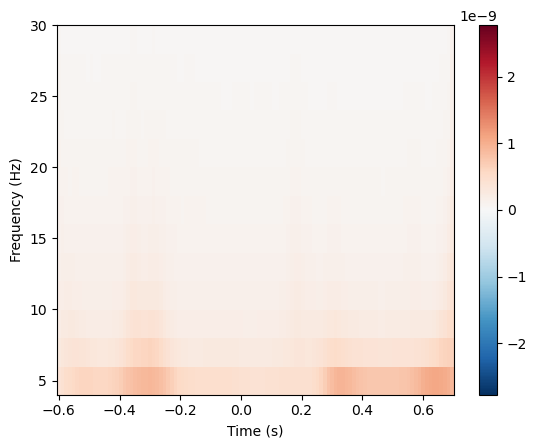

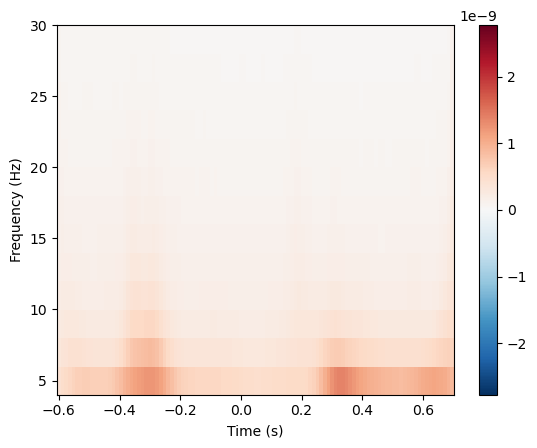

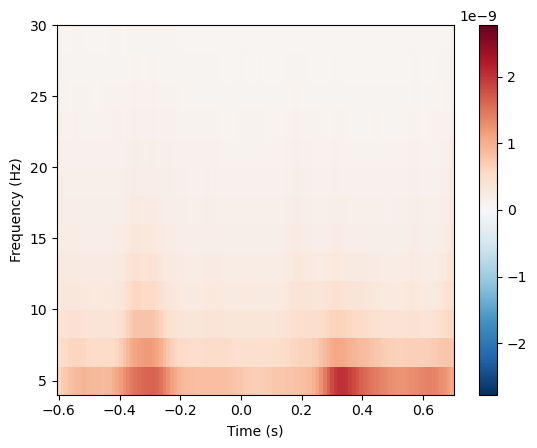

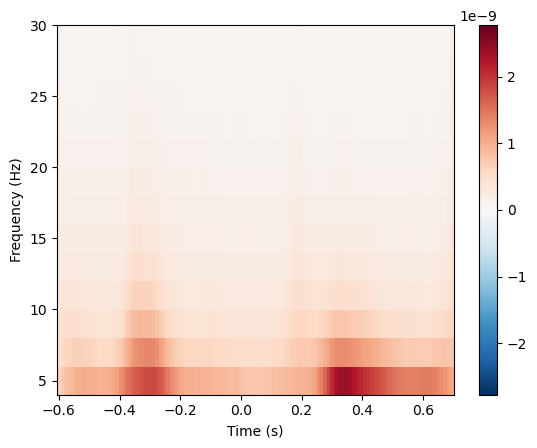

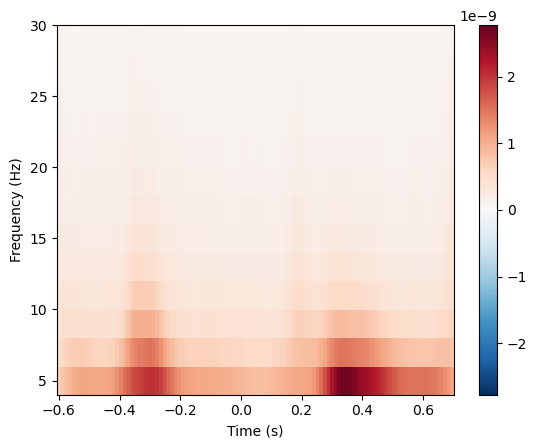

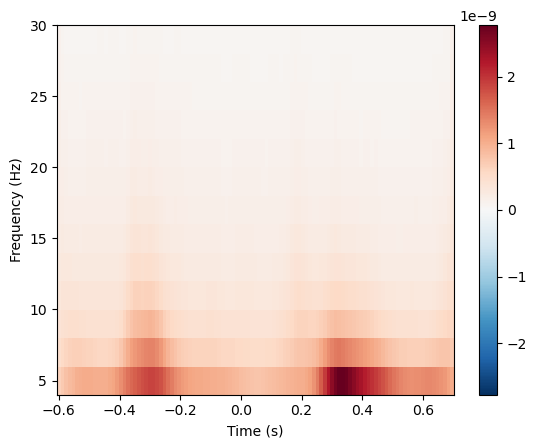

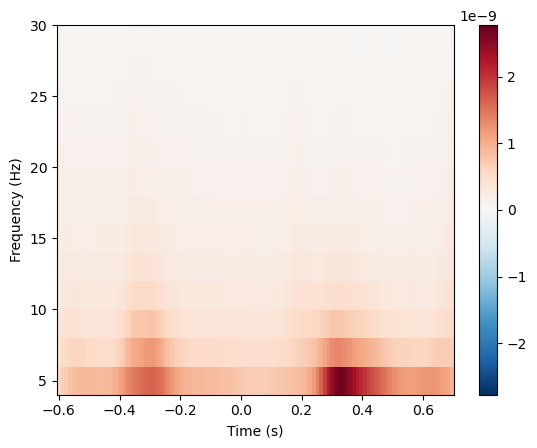

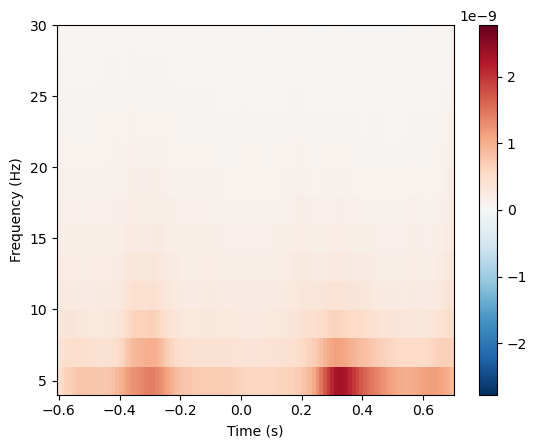

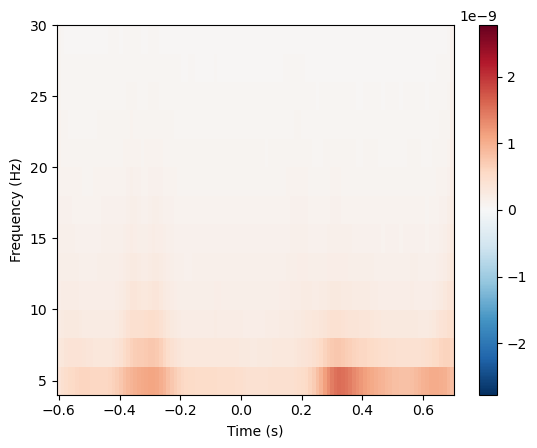

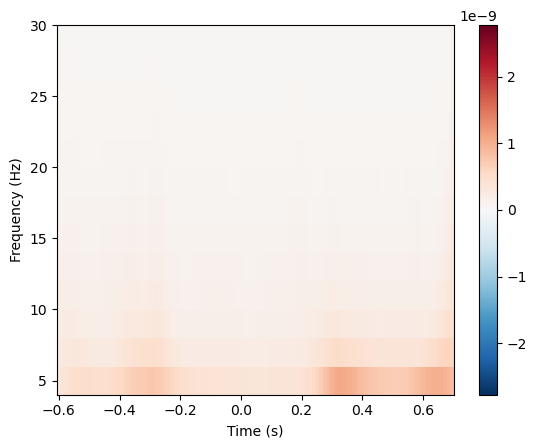

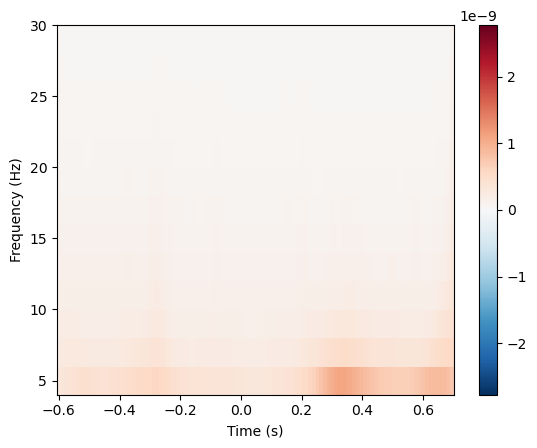

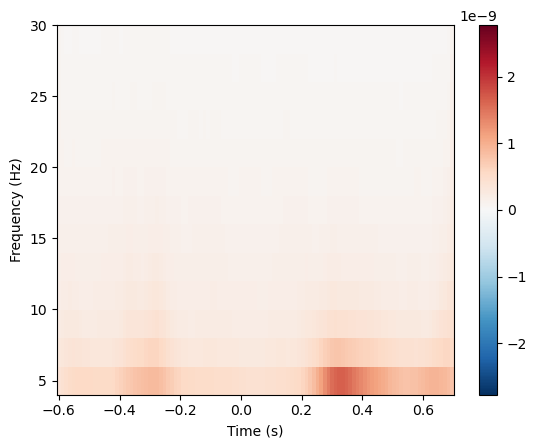

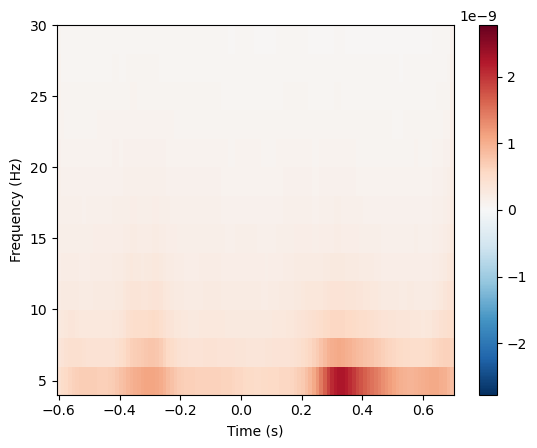

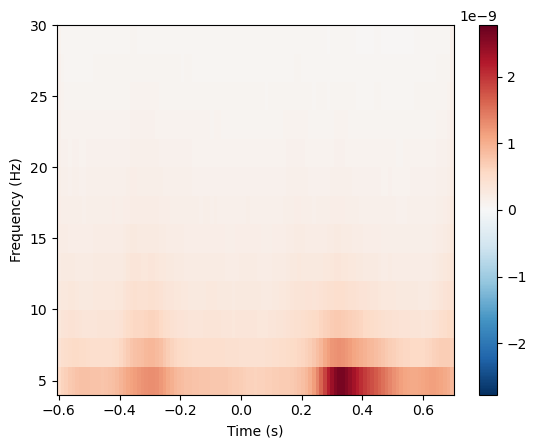

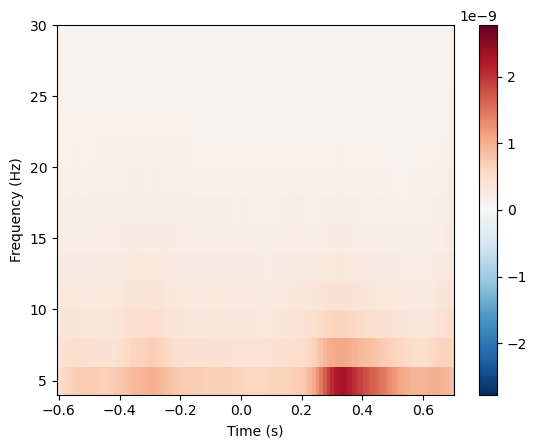

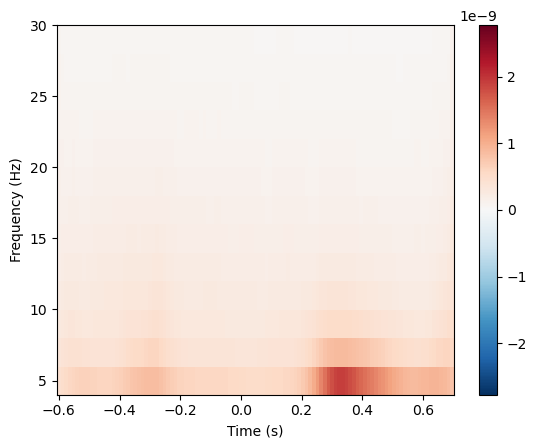

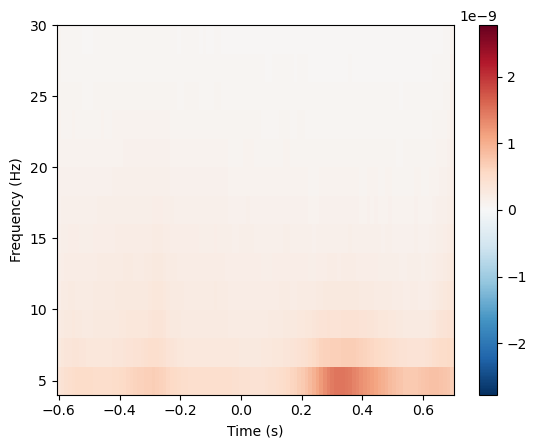

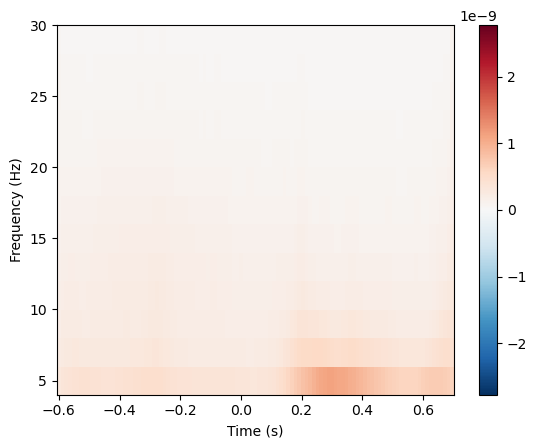

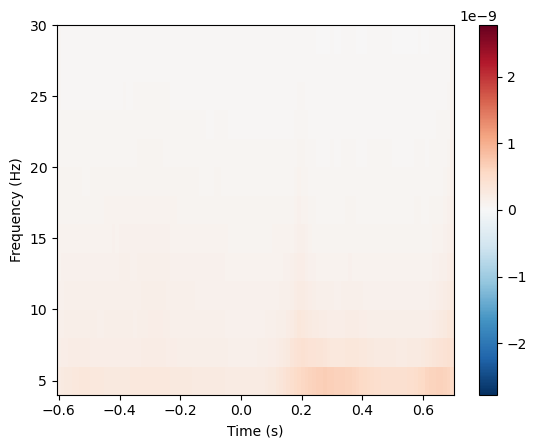

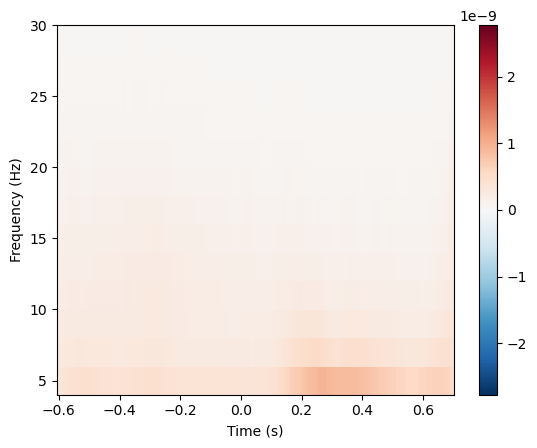

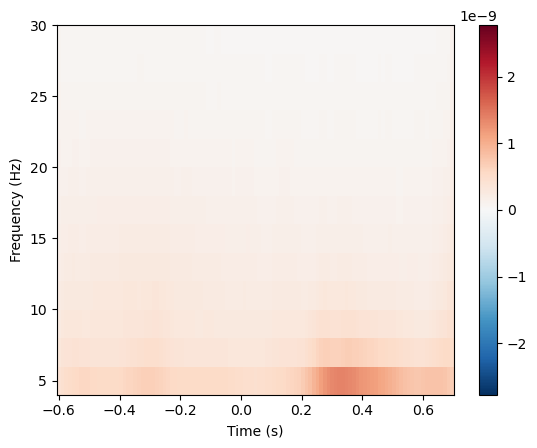

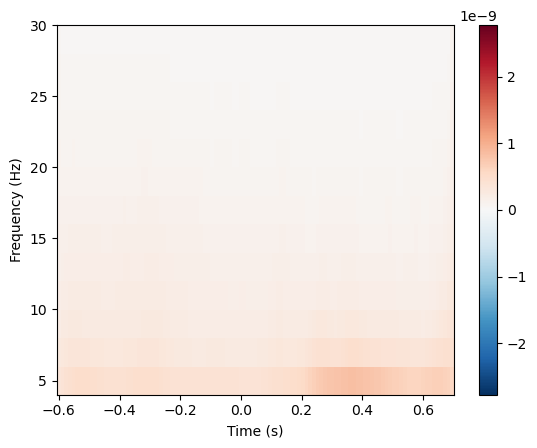

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2

In [98]:
power.plot()